In [1]:
# OS is used to interact the files and directories within the Operatiung System
import os
import random
import numpy as np
import pandas as pd
# Following three lines are used for the data visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Library for computer vision and image processing tasks, including object detection
import cv2
# Collection of algorithms for image processing. Provides tools for image segmentation, filtering, etc
import skimage
# Used for image transformation, such as resizing and geometric manipulations.
from skimage.transform import resize

# Tensorflow is used for building and training deep learning models.
# Keras is high-lvl Neural Network-API. It simplifies the process of building and training Neural Networks
import tensorflow as tf
from tensorflow import keras
# This API below provides utilities for tasks like one-hot encoding of labels (to_categorical)
from tensorflow.keras.utils import to_categorical
# Can create layers of Nueral Network models, stacked on each other, sequentially
from keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix


# Convo2D is used for image processing 
# MaxPooling2D is used in CNN to downsample the feature maps.
# Activation is like a filter that makes your NN more flexible and capable of recognizing complex patterns
# Dense layer keeps neurons close together to make important decisions based on what the network has learned
# Flatten flattens the structured data so that network can understand and analyze it easily
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
# Stops NN when the model's metric has stopped improving 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler


print("Packages imported...")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Packages imported...


In [2]:
train_dir = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
test_dir = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'

### Import the data (images)

In [3]:
batch_size = 64
imageSize = 64
target_dims = (imageSize, imageSize, 3)
num_classes = 29
train_len = 87000

# Create a dictionary to map folder names to labels
label_map = {
    'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7,
    'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14,
    'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21,
    'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28
}

def load_image(file_path):
    img = cv2.imread(file_path)
    if img is None:
        return None
    img = skimage.transform.resize(img, (imageSize, imageSize, 3))
    return img

def get_data(folder, label_map):
    X = []
    y = []
    
    for folderName in os.listdir(folder):
        if folderName not in label_map:
            continue  # Skip folders that are not in the mapping
        label = label_map[folderName]
        
        folder_path = os.path.join(folder, folderName)
        
        for image_filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_filename)
            img = load_image(image_path)
            
            if img is not None:
                X.append(img)
                y.append(label)
    
    return np.array(X), np.array(y)

X_train, y_train = get_data(train_dir, label_map)
print("Images successfully imported...")

Images successfully imported...


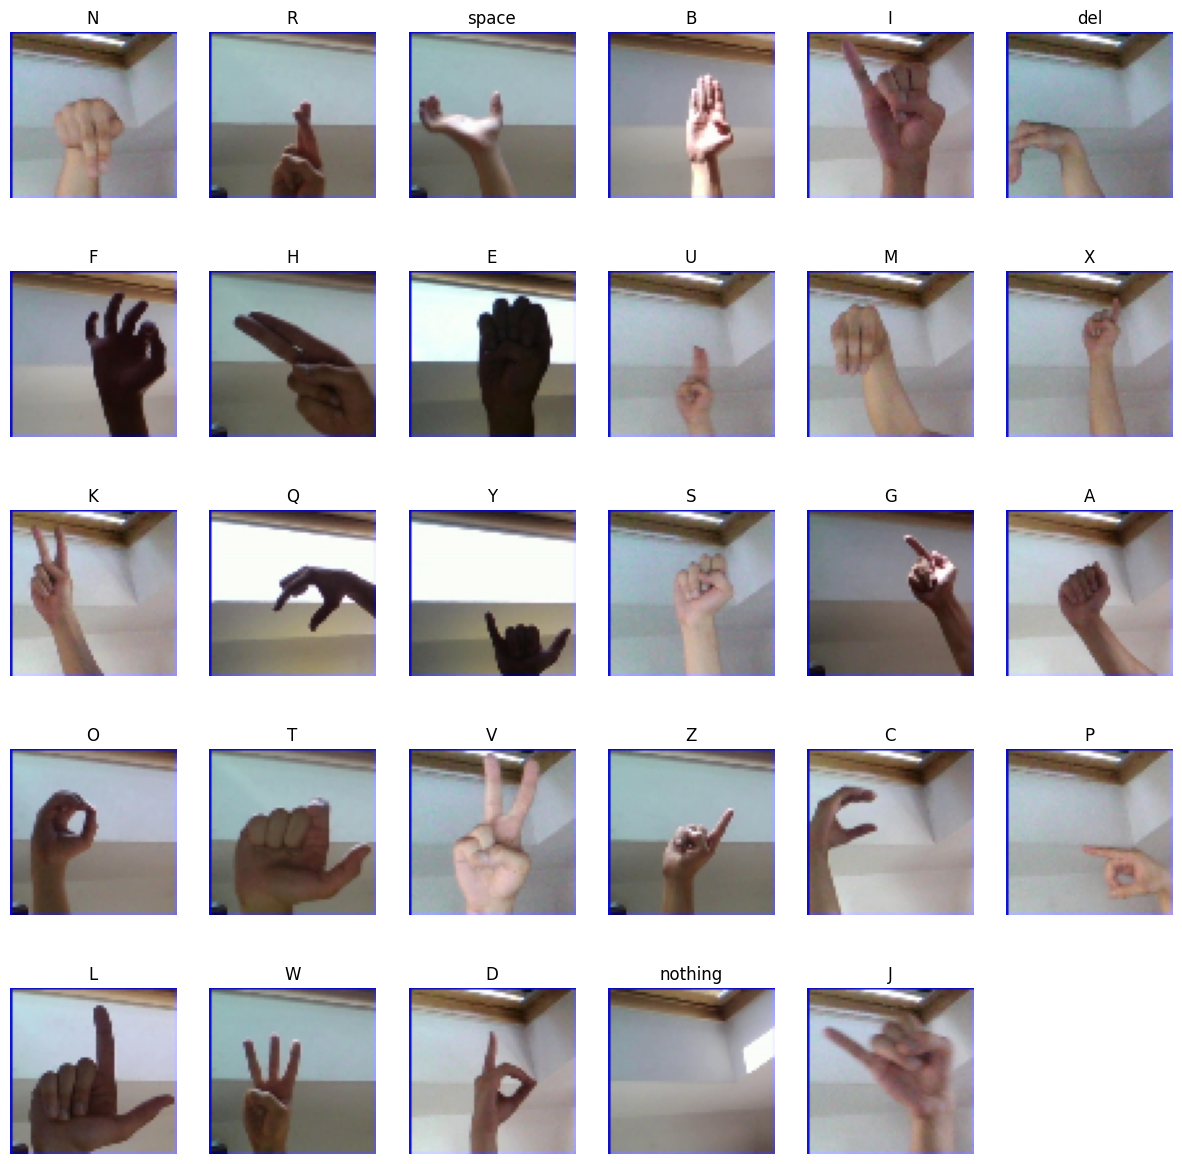

In [4]:
# Function to load and display unique images from the training directory
def load_and_display_unique_images():
    image_size = (64, 64)
    unique_images = []  # List to store unique images
    unique_labels = []  # List to store corresponding labels

    # Iterate through the folders in the training directory
    for folder in os.listdir(train_dir):
        for file in os.listdir(os.path.join(train_dir, folder)):
            file_path = os.path.join(train_dir, folder, file)
            image = cv2.imread(file_path)
            final_image = cv2.resize(image, image_size)
            final_image = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)
            
            # Append the unique image and its label
            unique_images.append(final_image)
            unique_labels.append(folder)
            break  # Only load one image per category

    return unique_images, unique_labels

# Load unique images and their labels
unique_images, unique_labels = load_and_display_unique_images()

# Display the unique images and their labels in a grid
fig = plt.figure(figsize=(15, 15))
def plot_image(fig, image, label, row, col, index):
    fig.add_subplot(row, col, index)
    plt.axis('off')
    plt.imshow(image)
    plt.title(label)

image_index = 0
rows, cols = 5, 6
for i in range(1, (rows * cols)):
    plot_image(fig, unique_images[image_index], unique_labels[image_index], rows, cols, i)
    image_index += 1

plt.show()

In [5]:
X_data = X_train
y_data = y_train
print("Creating new variables to avoid data mutation and maintaining code clarity...")

Creating new variables to avoid data mutation and maintaining code clarity...


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3,random_state=42,stratify=y_data)

In our case, our labels represent different classes (from 0 to 28), and one-hot encoding converts each label into a binary vector where only one element is "1" (hot) and the others are "0" (cold). This is necessary for models that require numerical inputs, such as neural networks.

In [7]:
# One-Hot-Encoding the categorical data
y_cat_train = to_categorical(y_train,29)
y_cat_test = to_categorical(y_test,29)

In [8]:
# Checking the dimensions of all the variables
print(X_train.shape)  # (60900, 64, 64, 3) - 60,900 samples, each with 64x64 pixels and 3 color channels
print(y_train.shape)  # (60900,) - 60,900 labels, one for each sample
print(X_test.shape)   # (26100, 64, 64, 3) - 26,100 testing samples with the same image dimensions
print(y_test.shape)   # (26100,) - 26,100 testing labels, one for each testing sample
print(y_cat_train.shape)  # (60900, 29) - 60,900 training labels as one-hot encoded vectors with 29 classes
print(y_cat_test.shape)   # (26100, 29) - 26,100 testing labels in one-hot encoded format

(60900, 64, 64, 3)
(60900,)
(26100, 64, 64, 3)
(26100,)
(60900, 29)
(26100, 29)


In [9]:
# Garbage Collector (gc) is responsible for cleaning up and freeing memory that is no longer in use
import gc
# By deleting these variables, we release the memory occupied by the copies of your data
del X_data
del y_data
# Explicitly triggers gc process to reclaim the memory that was no longer needed by deleting the above
# This makes the gc to run forcefully and recover the memory 
gc.collect()
# This practice helps prevent memory-related errors and keeps your code running smoothly.

45

Filters in Conv2D:
- Filters are small grids used to scan and find features in an image, like edges or patterns. They're learned by the network to recognize specific things.

Batch Normalization:
- It's like making sure everyone's voice is at the right volume in a choir. It helps the network learn faster and more reliably by keeping the numbers in each layer in a good range.

ReLU Activation:
- A rectified linear unit (ReLU) is an activation function that introduces the property of nonlinearity to a deep learning model and solves the vanishing gradients issue.
- It plays a significant role in igniting the hidden nodes to produce a more desirable output. The main purpose of the activation function is to introduce the property of nonlinearity into the model.

Max Pooling (MaxPooling2D):
- Imagine you have a big picture, and you want to see it in smaller parts. Max pooling takes small chunks (like 2x2 squares) of the image and keeps only the brightest pixel in each chunk. This helps make the image smaller and focuses on the most important parts.

In [10]:
model = Sequential()  # Create a sequential model

# Convolutional Layer 1
model.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3)))  # 32 filters, filter size (3, 3), input shape (64, 64, 3)
model.add(BatchNormalization())  # Apply batch normalization
model.add(Activation('relu'))  # Apply ReLU activation
model.add(MaxPooling2D((2, 2)))  # Apply max pooling with pool size (2, 2)

# Convolutional Layer 2
model.add(Conv2D(64, (3, 3)))  # 64 filters, filter size (3, 3)
model.add(BatchNormalization())  # Apply batch normalization
model.add(Activation('relu'))  # Apply ReLU activation
model.add(MaxPooling2D((2, 2)))  # Apply max pooling with pool size (2, 2)

# Convolutional Layer 3
model.add(Conv2D(128, (3, 3)))  # 128 filters, filter size (3, 3)
model.add(BatchNormalization())  # Apply batch normalization
model.add(Activation('relu'))  # Apply ReLU activation
model.add(MaxPooling2D((2, 2)))  # Apply max pooling with pool size (2, 2)

model.add(Flatten())  # Flatten the output from the convolutional layers

# Fully Connected Layer 1
model.add(Dense(256, activation='relu'))  # Dense layer with 256 units and ReLU activation
model.add(Dropout(0.5))  # Apply dropout with a rate of 0.5 to reduce overfitting

# Fully Connected Layer 2 (Output Layer)
model.add(Dense(29, activation='softmax'))  # Output layer with 29 units (for 29 classes) and softmax activation

model.summary()  # Display a summary of the model's architecture

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 29, 29, 64)       2

The purpose of using early stopping is to prevent your model from training for too long, which can lead to overfitting. Overfitting occurs when a model learns to perform well on the training data but doesn't generalize well to unseen data. Early stopping helps you find the point during training where the model's performance on the validation set starts to degrade, indicating that further training is unlikely to improve generalization.

In [11]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

Therefore, the above cell is used to automatically stop training your model if it doesn't improve on the validation loss for two consecutive epochs. It prevents your model from overfitting by finding the right time to stop training, ensuring it generalizes well to new data.

In [12]:
# define a learning rate schedule function that will adjusts the learning rate based on the current epoch
def lr_schedule(epoch):
    lr = 1e-3  # Initial learning rate set to 0.001 (1e-3).

    # If the current epoch is greater than 30, reduce the learning rate by a factor of 0.1.
    if epoch > 30:
        lr *= 0.1

    return lr

# Create an optimizer (in this case, Adam) and set its learning rate using the lr_schedule function.
optimizer = Adam(learning_rate=lr_schedule(0))

# Compile the model with the defined optimizer, loss function, and evaluation metrics.
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Fit the model using the training data and labels (X_train, y_cat_train).
# Training will run for a total of 50 epochs.
# Data will be processed in batches of size 64 (batch_size).
# Verbose mode 2 will display training progress with one line per epoch.
# Validation data (X_test, y_cat_test) is used to monitor model performance on unseen data.
# Callbacks are used to control training behavior.

model.fit(X_train,  # Training data
          y_cat_train,  # Training labels (one-hot encoded)
          epochs=50,  # Total number of training epochs
          batch_size=64,  # Batch size for processing data
          verbose=2,  # Display training progress (2 for one line per epoch)
          validation_data=(X_test, y_cat_test),  # Validation data for monitoring performance
          callbacks=[early_stop, LearningRateScheduler(lr_schedule)])  # Callbacks for custom training control

Epoch 1/50
952/952 - 20s - loss: 2.7053 - accuracy: 0.1606 - val_loss: 2.1971 - val_accuracy: 0.3426 - lr: 0.0010 - 20s/epoch - 21ms/step
Epoch 2/50
952/952 - 9s - loss: 2.0107 - accuracy: 0.3052 - val_loss: 1.2185 - val_accuracy: 0.6209 - lr: 0.0010 - 9s/epoch - 9ms/step
Epoch 3/50
952/952 - 9s - loss: 1.8000 - accuracy: 0.3598 - val_loss: 1.6947 - val_accuracy: 0.4519 - lr: 0.0010 - 9s/epoch - 9ms/step
Epoch 4/50
952/952 - 9s - loss: 1.6946 - accuracy: 0.3956 - val_loss: 1.1136 - val_accuracy: 0.6495 - lr: 0.0010 - 9s/epoch - 9ms/step
Epoch 5/50
952/952 - 9s - loss: 1.6060 - accuracy: 0.4248 - val_loss: 0.9017 - val_accuracy: 0.6661 - lr: 0.0010 - 9s/epoch - 9ms/step
Epoch 6/50
952/952 - 9s - loss: 1.5602 - accuracy: 0.4428 - val_loss: 0.6774 - val_accuracy: 0.8278 - lr: 0.0010 - 9s/epoch - 9ms/step
Epoch 7/50
952/952 - 9s - loss: 1.5136 - accuracy: 0.4586 - val_loss: 0.6091 - val_accuracy: 0.8470 - lr: 0.0010 - 9s/epoch - 9ms/step
Epoch 8/50
952/952 - 9s - loss: 1.4618 - accuracy: 0

#### Plotting the model performance metrics to check model performance.

In [14]:
# Model Metrics
metrics = pd.DataFrame(model.history.history)
print("The model metrics are")
metrics

The model metrics are


,loss,accuracy,val_loss,val_accuracy,lr
0,2.705262,0.160608,2.197145,0.342644,0.001
1,2.010719,0.305222,1.218493,0.620881,0.001
2,1.799963,0.359803,1.694664,0.451877,0.001
3,1.694568,0.395599,1.113607,0.649464,0.001
4,1.606033,0.424811,0.901738,0.666054,0.001
5,1.560171,0.442791,0.677446,0.827816,0.001
6,1.513573,0.458621,0.609074,0.847050,0.001
7,1.461846,0.482282,0.698375,0.780153,0.001
8,1.408145,0.500263,0.518486,0.844521,0.001
9,1.283854,0.541970,0.433178,0.883372,0.001


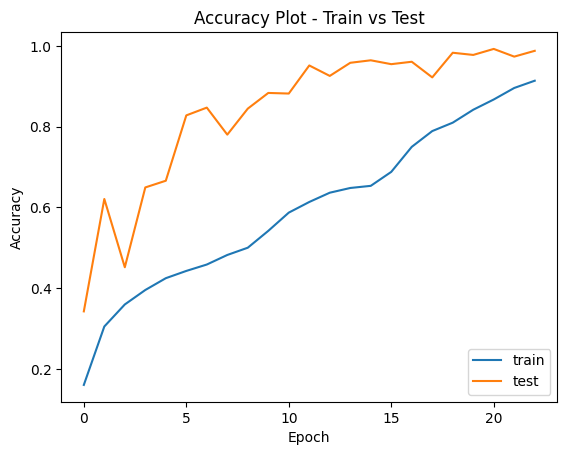

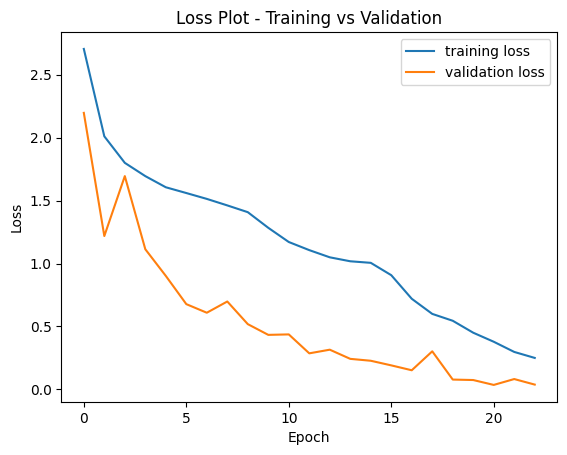

In [15]:
# Plotting training and testing accuracy
plt.plot(metrics['accuracy'])  # Plot training accuracy
plt.plot(metrics['val_accuracy'])  # Plot testing accuracy
plt.legend(['train', 'test'], loc='lower right')
plt.title('Accuracy Plot - Train vs Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plotting training and validation loss
plt.plot(metrics['loss'])  # Plots training loss
plt.plot(metrics['val_loss'])  # Plots validation loss
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.title('Loss Plot - Training vs Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [16]:
# Model Evaluation
evaluate_metrics = model.evaluate(X_test,y_cat_test,verbose=0)

# Print the evaluation results
print("Evaluation Accuracy = {:.2f}%".format(evaluate_metrics[1] * 100))
print("Evaluation Loss = {:.6f}".format(evaluate_metrics[0]))

Evaluation Accuracy = 98.76%
Evaluation Loss = 0.038086


In [17]:
# PREDICTION
predictions = model.predict(X_test)

# Since our output layer uses softmax activation, the predictions are probabilities for each class.
# To get the predicted class, find the index of the highest probability for each image.
predicted_classes = np.argmax(predictions, axis=1)

# Now, we can compare predicted classes with the actual classes (y_test) to evaluate the model's performance.
# Print the classification report and confusion matrix to assess the model's accuracy.
print(classification_report(np.argmax(y_cat_test, axis=1), predicted_classes))

816/816 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       900
           1       0.99      0.99      0.99       900
           2       1.00      1.00      1.00       900
           3       1.00      1.00      1.00       900
           4       0.92      0.95      0.94       900
           5       1.00      1.00      1.00       900
           6       0.99      0.99      0.99       900
           7       1.00      0.99      0.99       900
           8       0.98      0.99      0.99       900
           9       1.00      0.99      1.00       900
          10       1.00      0.99      0.99       900
          11       1.00      1.00      1.00       900
          12       1.00      0.97      0.99       900
          13       0.97      1.00      0.98       900
          14       1.00      1.00      1.00       900
          15       0.99      1.00      1.00       900
          16       1.00   

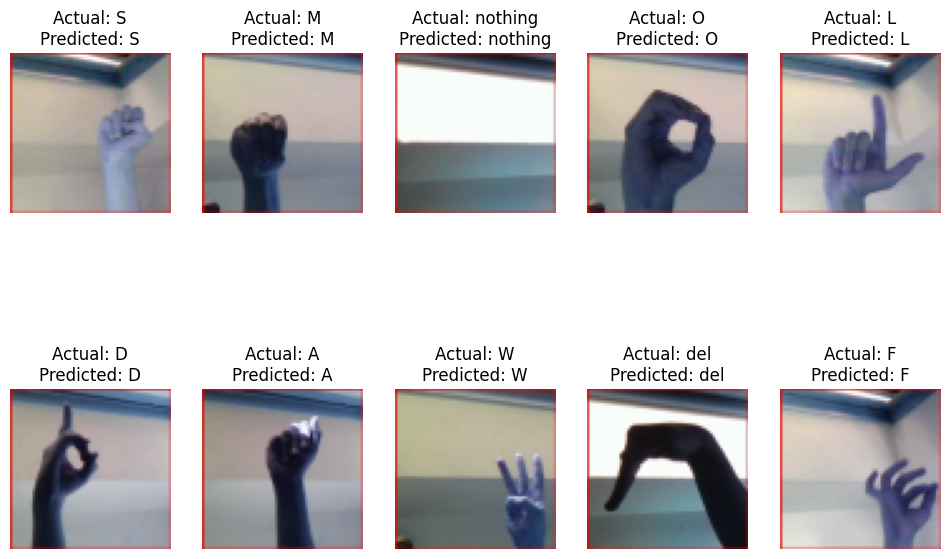

In [18]:
# To visualize how well our model is doing, we can plot some test images along with their predicted labels.
# Choose random test images and their corresponding predicted labels for visualization.
num_samples = 10  # We can change this to the number of samples we want to visualize.
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 
          'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
          'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


plt.figure(figsize=(12, 8))
for i in range(num_samples):
    index = random.randint(0, len(X_test) - 1)
    plt.subplot(2, num_samples // 2, i + 1)
    plt.imshow(X_test[index])
    plt.title(f"Actual: {labels[y_test[index]]}\nPredicted: {labels[predicted_classes[index]]}")
    plt.axis('off')

plt.show()

#### Not bad!!

In [19]:
from keras.models import load_model
model.save('ASL_fudge_fantastic_1.h5')
print("Model saved successfully...")

Model saved successfully...
